In [187]:
import requests
import time
import tqdm
import pandas as pd
import os
import json
import openpyxl 
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import NaN
import seaborn as sns
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [188]:
fp_data = Path.cwd() / "data" 
Path.mkdir(fp_data, exist_ok=True)  
print(fp_data)

C:\Users\Bruger\OneDrive\Dokumenter\GitHub\isds2023\assignments\Exam project\data


In [189]:
def construct_link(table_id, variables):
    base = f'https://api.statbank.dk/v1/data/{table_id}/JSONSTAT?lang=en'
    
    for var in variables:
        base += f'&{var}'

    return base 

construct_link('MPK3', ['Tid=*', 'Type=5500602011'])
#API FOR loan interest rate 
#It refers to the interest rate that banks and financial institutions charge for lending money to individuals, businesses, and other institutions.
url = construct_link('MPK3', ['Tid=*', 'Type=5500602011'])

def create_data(url):
    response = requests.get(url).json()
    values = response['dataset']['value']
    years = response['dataset']['dimension']['Tid']['category']['index']
    data = dict(zip(years, values))
    return data

Interest_rate = create_data(url)

interest_rate_df = pd.DataFrame(Interest_rate.items(), columns=['Year', 'Loan interest rate']).dropna()


In [190]:
interest_rate_df['datetime'] = pd.to_datetime(interest_rate_df['Year'], format = '%YM%m')
interest_rate_df['month'] = interest_rate_df['datetime'].dt.month
interest_rate_df['year']= interest_rate_df['datetime'].dt.year
interest_rate_df['quarter']=interest_rate_df['datetime'].dt.quarter

interest_rate_df['year + quarter'] = interest_rate_df['year'].astype(str) + 'K' + interest_rate_df['quarter'].astype(str)
interest_rate_df.set_index('year + quarter', inplace=True)

In [191]:
interest_rate_df.drop('datetime', axis=1, inplace=True)
interest_rate_df.drop('month', axis=1, inplace=True)
interest_rate_df.drop('Year', axis=1, inplace=True)
interest_rate_df.drop('quarter', axis=1, inplace=True)
interest_rate_df.drop('year', axis=1, inplace=True)

In [237]:

file_path= fp_data / 'combined_data.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)


In [238]:
df.columns= ['type and adress', 'price', 'date and type', 'm2 and kr/m2', 'rooms', 'year built', 'difference', 'idk'] 

In [239]:
# Substring to search for
# Split the column based on the substring "Eejerlejlighed"
df['address'] = df['type and adress'].apply(lambda x: x.split("EEjerlejlighed", 1)[-1].strip())


In [240]:
df['type'] = df['type and adress'].apply(lambda x: x.split("EEjerlejlighed", 1)[0].strip())


In [241]:
df.drop('type and adress', axis=1, inplace=True)

In [242]:
df['date']=df['date and type'].apply(lambda x: x.split("Alm.", 1)[0].strip())

In [243]:
df['sales type']=df['date and type'].apply(lambda x: x[10:])

In [244]:
df.drop('date and type', axis=1, inplace=True)

In [245]:
df['kr/m2']=df['m2 and kr/m2'].apply(lambda x: x.split('m²', 1)[-1].strip())

In [246]:
df['m2']=df['m2 and kr/m2'].apply(lambda x: x.split('m²', 1)[0].strip())

In [247]:
df.drop('m2 and kr/m2', axis=1, inplace=True)

In [248]:
df['datetime'] = pd.to_datetime(df['date'], format = '%d-%m-%Y')
df['month'] = df['datetime'].dt.month
df['year']= df['datetime'].dt.year
df['quarter']=df['datetime'].dt.quarter

df['year + quarter'] = df['year'].astype(str) + 'K' + df['quarter'].astype(str)
df.set_index('year + quarter', inplace=True)

In [249]:
df.drop('datetime', axis=1, inplace=True)
df.drop('month', axis=1, inplace=True)
df.drop('year', axis=1, inplace=True)
df.drop('quarter', axis=1, inplace=True)

In [250]:
#check if there are any missing values 
missing_values = df.isnull().sum()
missing_values
#there are none


price             0
rooms             0
year built        0
difference    31010
idk               0
address           0
type              0
date              0
sales type        0
kr/m2             0
m2                0
dtype: int64

In [257]:
outer_merge = pd.merge(interest_rate_df, df, on='year + quarter', how='outer')
outer_merge.dropna()


,Loan interest rate,price,rooms,year built,difference,idk,address,type,date,sales type,kr/m2,m2
year + quarter,,,,,,,,,,,,
2017K1,0.05,4.495.000 kr.,5.0,1885.0,-3%,Aktuel værdi,"Kroghsgade 5, st. th 2100 København Ø",Ejerlejlighed,30-03-2017,Alm. Salg,40.864 kr/m²,110
2017K1,0.05,1.375.000 kr.,3.0,1963.0,-5%,Aktuel værdi,"Brinchs Have 13, st. tv 2630 Taastrup",Ejerlejlighed,30-03-2017,Alm. Salg,19.643 kr/m²,70
2017K1,0.05,1.850.000 kr.,2.0,1934.0,-2%,Aktuel værdi,"Ordrupvej 98D, 3. th 2920 Charlottenlund",Ejerlejlighed,30-03-2017,Alm. Salg,31.897 kr/m²,58
2017K1,0.05,2.285.000 kr.,4.0,1961.0,0%,Aktuel værdi,"Askevænget 41, 1. th 2830 Virum",Ejerlejlighed,30-03-2017,Alm. Salg,26.570 kr/m²,86
2017K1,0.05,1.850.000 kr.,2.0,1935.0,-2%,Aktuel værdi,"Sandbjerggade 52, 4. th 2200 København N",Ejerlejlighed,30-03-2017,Alm. Salg,34.906 kr/m²,53
...,...,...,...,...,...,...,...,...,...,...,...,...
2023K2,3.25,4.600.000 kr.,2.0,1904.0,-8%,Aktuel værdi,"Lykkesholms Allé 7B, st. th 1902 Frederiksberg C",Ejerlejlighed,01-04-2023,Alm. Salg,61.333 kr/m²,75
2023K2,3.25,4.580.000 kr.,3.0,1890.0,-4%,Aktuel værdi,"Nyelandsvej 1, 1. th 2000 Frederiksberg",Ejerlejlighed,01-04-2023,Alm. Salg,47.216 kr/m²,97
2023K2,3.25,1.700.000 kr.,1.0,1970.0,-7%,Aktuel værdi,"Birketinget 2E, 3. 532 2300 København S",Ejerlejlighed,01-04-2023,Alm. Salg,37.778 kr/m²,45


In [258]:
#API for consumer price index 
url = construct_link('PRIS111', ['Tid=*', 'VAREGR=000000', 'Enhed=100'])

def create_data(url):
    response = requests.get(url).json()
    values = response['dataset']['value']
    years = response['dataset']['dimension']['Tid']['category']['index']
    data = dict(zip(years, values))
    return data

Consumer_price_index = create_data(url)
Consumer_price_index_df = pd.DataFrame(Consumer_price_index.items(), columns=['Year', 'Consumer Price Index']).dropna()

In [259]:
Consumer_price_index_df['datetime'] = pd.to_datetime(Consumer_price_index_df['Year'], format = '%YM%m')
Consumer_price_index_df['month'] = Consumer_price_index_df['datetime'].dt.month
Consumer_price_index_df['year']= Consumer_price_index_df['datetime'].dt.year
Consumer_price_index_df['quarter']=Consumer_price_index_df['datetime'].dt.quarter

Consumer_price_index_df['year + quarter'] = Consumer_price_index_df['year'].astype(str) + 'K' + Consumer_price_index_df['quarter'].astype(str)
Consumer_price_index_df.set_index('year + quarter', inplace=True)


In [260]:
Consumer_price_index_df.drop('datetime', axis=1, inplace=True)
Consumer_price_index_df.drop('month', axis=1, inplace=True)
Consumer_price_index_df.drop('Year', axis=1, inplace=True)
Consumer_price_index_df.drop('quarter', axis=1, inplace=True)
Consumer_price_index_df.drop('year', axis=1, inplace=True)


In [261]:
outer_merge1 = pd.merge(Consumer_price_index_df, outer_merge, on='year + quarter', how='outer')
outer_merge1.dropna()


,Consumer Price Index,Loan interest rate,price,rooms,year built,difference,idk,address,type,date,sales type,kr/m2,m2
year + quarter,,,,,,,,,,,,,
2017K1,100.3,0.05,4.495.000 kr.,5.0,1885.0,-3%,Aktuel værdi,"Kroghsgade 5, st. th 2100 København Ø",Ejerlejlighed,30-03-2017,Alm. Salg,40.864 kr/m²,110
2017K1,100.3,0.05,1.375.000 kr.,3.0,1963.0,-5%,Aktuel værdi,"Brinchs Have 13, st. tv 2630 Taastrup",Ejerlejlighed,30-03-2017,Alm. Salg,19.643 kr/m²,70
2017K1,100.3,0.05,1.850.000 kr.,2.0,1934.0,-2%,Aktuel værdi,"Ordrupvej 98D, 3. th 2920 Charlottenlund",Ejerlejlighed,30-03-2017,Alm. Salg,31.897 kr/m²,58
2017K1,100.3,0.05,2.285.000 kr.,4.0,1961.0,0%,Aktuel værdi,"Askevænget 41, 1. th 2830 Virum",Ejerlejlighed,30-03-2017,Alm. Salg,26.570 kr/m²,86
2017K1,100.3,0.05,1.850.000 kr.,2.0,1935.0,-2%,Aktuel værdi,"Sandbjerggade 52, 4. th 2200 København N",Ejerlejlighed,30-03-2017,Alm. Salg,34.906 kr/m²,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023K2,116.4,3.25,4.600.000 kr.,2.0,1904.0,-8%,Aktuel værdi,"Lykkesholms Allé 7B, st. th 1902 Frederiksberg C",Ejerlejlighed,01-04-2023,Alm. Salg,61.333 kr/m²,75
2023K2,116.4,3.25,4.580.000 kr.,3.0,1890.0,-4%,Aktuel værdi,"Nyelandsvej 1, 1. th 2000 Frederiksberg",Ejerlejlighed,01-04-2023,Alm. Salg,47.216 kr/m²,97
2023K2,116.4,3.25,1.700.000 kr.,1.0,1970.0,-7%,Aktuel værdi,"Birketinget 2E, 3. 532 2300 København S",Ejerlejlighed,01-04-2023,Alm. Salg,37.778 kr/m²,45


In [262]:
#monthly inflation: percentage monthly change in consumer price index
url = construct_link('PRIS111', ['Tid=*', 'VAREGR=000000', 'Enhed=200'])

def create_data(url):
    response = requests.get(url).json()
    values = response['dataset']['value']
    years = response['dataset']['dimension']['Tid']['category']['index']
    data = dict(zip(years, values))
    return data

Inflation = create_data(url)
Inflation_df = pd.DataFrame(Consumer_price_index.items(), columns=['Year', 'Inflation']).dropna()

Inflation_df['datetime'] = pd.to_datetime(Inflation_df['Year'], format = '%YM%m')
Inflation_df['month'] = Inflation_df['datetime'].dt.month
Inflation_df['year']= Inflation_df['datetime'].dt.year
Inflation_df['quarter']=Inflation_df['datetime'].dt.quarter

Inflation_df['year + quarter'] = Inflation_df['year'].astype(str) + 'K' + Inflation_df['quarter'].astype(str)
Inflation_df.set_index('year + quarter', inplace=True)

Inflation_df.drop('datetime', axis=1, inplace=True)
Inflation_df.drop('month', axis=1, inplace=True)
Inflation_df.drop('Year', axis=1, inplace=True)
Inflation_df.drop('quarter', axis=1, inplace=True)
Inflation_df.drop('year', axis=1, inplace=True)

Inflation_df

,Inflation
year + quarter,
2001K1,76.7
2001K1,77.3
2001K1,77.7
2001K2,78.0
2001K2,78.4
...,...
2023K1,117.3
2023K2,117.6
2023K2,116.0


In [263]:
outer_merge2 = pd.merge(Inflation_df, outer_merge1, on='year + quarter', how='outer')
outer_merge2.dropna()


,Inflation,Consumer Price Index,Loan interest rate,price,rooms,year built,difference,idk,address,type,date,sales type,kr/m2,m2
year + quarter,,,,,,,,,,,,,,
2017K1,100.3,100.3,0.05,4.495.000 kr.,5.0,1885.0,-3%,Aktuel værdi,"Kroghsgade 5, st. th 2100 København Ø",Ejerlejlighed,30-03-2017,Alm. Salg,40.864 kr/m²,110
2017K1,100.3,100.3,0.05,1.375.000 kr.,3.0,1963.0,-5%,Aktuel værdi,"Brinchs Have 13, st. tv 2630 Taastrup",Ejerlejlighed,30-03-2017,Alm. Salg,19.643 kr/m²,70
2017K1,100.3,100.3,0.05,1.850.000 kr.,2.0,1934.0,-2%,Aktuel værdi,"Ordrupvej 98D, 3. th 2920 Charlottenlund",Ejerlejlighed,30-03-2017,Alm. Salg,31.897 kr/m²,58
2017K1,100.3,100.3,0.05,2.285.000 kr.,4.0,1961.0,0%,Aktuel værdi,"Askevænget 41, 1. th 2830 Virum",Ejerlejlighed,30-03-2017,Alm. Salg,26.570 kr/m²,86
2017K1,100.3,100.3,0.05,1.850.000 kr.,2.0,1935.0,-2%,Aktuel værdi,"Sandbjerggade 52, 4. th 2200 København N",Ejerlejlighed,30-03-2017,Alm. Salg,34.906 kr/m²,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023K2,116.4,116.4,3.25,4.600.000 kr.,2.0,1904.0,-8%,Aktuel værdi,"Lykkesholms Allé 7B, st. th 1902 Frederiksberg C",Ejerlejlighed,01-04-2023,Alm. Salg,61.333 kr/m²,75
2023K2,116.4,116.4,3.25,4.580.000 kr.,3.0,1890.0,-4%,Aktuel værdi,"Nyelandsvej 1, 1. th 2000 Frederiksberg",Ejerlejlighed,01-04-2023,Alm. Salg,47.216 kr/m²,97
2023K2,116.4,116.4,3.25,1.700.000 kr.,1.0,1970.0,-7%,Aktuel værdi,"Birketinget 2E, 3. 532 2300 København S",Ejerlejlighed,01-04-2023,Alm. Salg,37.778 kr/m²,45


In [264]:
#API for salary (this one is quarterly) 
#Standardised index of average earnings (2016=100) 

url = construct_link('SBLON1', ['Tid=*', 'BRANCHE07=*', 'VARIA1=100', 'SEKTOR=1000'])
def create_data(url):
    response = requests.get(url).json()
    values = response['dataset']['value']
    years = response['dataset']['dimension']['Tid']['category']['index']
    data = dict(zip(years, values))
    return data

salary_df = create_data(url)


In [265]:
# Create a DataFrame
salary_df = pd.DataFrame(salary_df.items(), columns=['year + quarter', 'Salary']).dropna()
salary_df.set_index('year + quarter', inplace=True)

outer_merge3 = pd.merge(salary_df, outer_merge2, on='year + quarter', how='outer')
outer_merge3.dropna()

,Salary,Inflation,Consumer Price Index,Loan interest rate,price,rooms,year built,difference,idk,address,type,date,sales type,kr/m2,m2
year + quarter,,,,,,,,,,,,,,,
2017K1,100.8,100.3,100.3,0.05,4.495.000 kr.,5.0,1885.0,-3%,Aktuel værdi,"Kroghsgade 5, st. th 2100 København Ø",Ejerlejlighed,30-03-2017,Alm. Salg,40.864 kr/m²,110
2017K1,100.8,100.3,100.3,0.05,1.375.000 kr.,3.0,1963.0,-5%,Aktuel værdi,"Brinchs Have 13, st. tv 2630 Taastrup",Ejerlejlighed,30-03-2017,Alm. Salg,19.643 kr/m²,70
2017K1,100.8,100.3,100.3,0.05,1.850.000 kr.,2.0,1934.0,-2%,Aktuel værdi,"Ordrupvej 98D, 3. th 2920 Charlottenlund",Ejerlejlighed,30-03-2017,Alm. Salg,31.897 kr/m²,58
2017K1,100.8,100.3,100.3,0.05,2.285.000 kr.,4.0,1961.0,0%,Aktuel værdi,"Askevænget 41, 1. th 2830 Virum",Ejerlejlighed,30-03-2017,Alm. Salg,26.570 kr/m²,86
2017K1,100.8,100.3,100.3,0.05,1.850.000 kr.,2.0,1935.0,-2%,Aktuel værdi,"Sandbjerggade 52, 4. th 2200 København N",Ejerlejlighed,30-03-2017,Alm. Salg,34.906 kr/m²,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023K1,115.3,117.3,117.3,2.75,2.700.000 kr.,4.0,1965.0,-3%,Aktuel værdi,"Gladsaxe Møllevej 109, 2 2860 Søborg",Ejerlejlighed,01-01-2023,Alm. Salg,32.927 kr/m²,82
2023K1,115.3,117.3,117.3,2.75,5.750.000 kr.,4.0,1905.0,-11%,Aktuel værdi,"Sankt Thomas Alle 6, 1. tv 1824 Frederiksberg C",Ejerlejlighed,01-01-2023,Alm. Salg,58.081 kr/m²,99
2023K1,115.3,117.3,117.3,2.75,2.700.000 kr.,2.0,1990.0,-7%,Aktuel værdi,"Allersgade 2, 2. mf 2200 København N",Ejerlejlighed,01-01-2023,Alm. Salg,38.571 kr/m²,70


In [266]:
#API for GDP (are we in an economic boom --> could maybe create a binary variable with a yes or no) 
#chose to use chained values because account for changes in price levels over time, making them suitable for comparing economic 
#data across different time periods while adjusting for inflation or deflation. This is important because GDP and housing prices 
#can be affected by changes in the general price level, and using chained values helps to isolate the real changes in these variables.

url = construct_link('NKN1', ['Tid=*', 'S%C3%86SON=*', 'PRISENHED=LKV_M', 'TRANSAKT=B1GQK'])

def create_data(url):
    response = requests.get(url).json()
    values = response['dataset']['value']
    years = response['dataset']['dimension']['Tid']['category']['index']
    data = dict(zip(years, values))
    return data

gdp= create_data(url)
gdp_df = pd.DataFrame(gdp.items(), columns=['year + quarter', 'GDP']).dropna()
gdp_df.set_index('year + quarter', inplace=True)

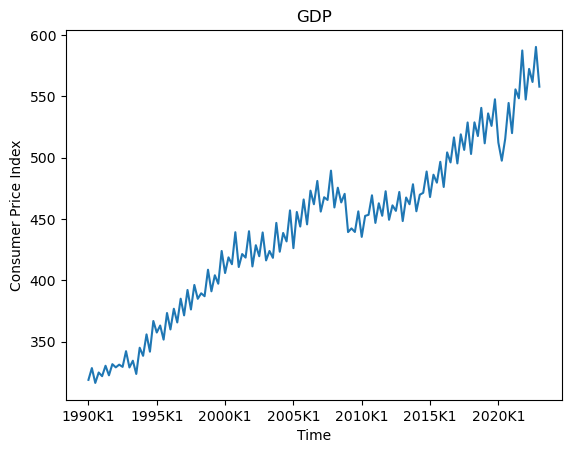

In [267]:
gdp_df

gdp_df['GDP'].plot()
plt.title("GDP")
plt.xlabel("Time")
plt.ylabel("Consumer Price Index")
plt.show()

In [268]:
outer_merge4 = pd.merge(gdp_df, outer_merge3, on='year + quarter', how='outer')

In [269]:
Final_data_set=outer_merge4.dropna()

In [271]:
Final_data_set

,GDP,Salary,Inflation,Consumer Price Index,Loan interest rate,price,rooms,year built,difference,idk,address,type,date,sales type,kr/m2,m2
year + quarter,,,,,,,,,,,,,,,,
2017K1,495.4,100.8,100.3,100.3,0.05,4.495.000 kr.,5.0,1885.0,-3%,Aktuel værdi,"Kroghsgade 5, st. th 2100 København Ø",Ejerlejlighed,30-03-2017,Alm. Salg,40.864 kr/m²,110
2017K1,495.4,100.8,100.3,100.3,0.05,1.375.000 kr.,3.0,1963.0,-5%,Aktuel værdi,"Brinchs Have 13, st. tv 2630 Taastrup",Ejerlejlighed,30-03-2017,Alm. Salg,19.643 kr/m²,70
2017K1,495.4,100.8,100.3,100.3,0.05,1.850.000 kr.,2.0,1934.0,-2%,Aktuel værdi,"Ordrupvej 98D, 3. th 2920 Charlottenlund",Ejerlejlighed,30-03-2017,Alm. Salg,31.897 kr/m²,58
2017K1,495.4,100.8,100.3,100.3,0.05,2.285.000 kr.,4.0,1961.0,0%,Aktuel værdi,"Askevænget 41, 1. th 2830 Virum",Ejerlejlighed,30-03-2017,Alm. Salg,26.570 kr/m²,86
2017K1,495.4,100.8,100.3,100.3,0.05,1.850.000 kr.,2.0,1935.0,-2%,Aktuel værdi,"Sandbjerggade 52, 4. th 2200 København N",Ejerlejlighed,30-03-2017,Alm. Salg,34.906 kr/m²,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023K1,558.0,115.3,117.3,117.3,2.75,2.700.000 kr.,4.0,1965.0,-3%,Aktuel værdi,"Gladsaxe Møllevej 109, 2 2860 Søborg",Ejerlejlighed,01-01-2023,Alm. Salg,32.927 kr/m²,82
2023K1,558.0,115.3,117.3,117.3,2.75,5.750.000 kr.,4.0,1905.0,-11%,Aktuel værdi,"Sankt Thomas Alle 6, 1. tv 1824 Frederiksberg C",Ejerlejlighed,01-01-2023,Alm. Salg,58.081 kr/m²,99
2023K1,558.0,115.3,117.3,117.3,2.75,2.700.000 kr.,2.0,1990.0,-7%,Aktuel værdi,"Allersgade 2, 2. mf 2200 København N",Ejerlejlighed,01-01-2023,Alm. Salg,38.571 kr/m²,70


In [272]:
#delete consumer price index
Final_data_set['price'] = Final_data_set['price'].str[:-3]
Final_data_set['kr/m2'] = Final_data_set['kr/m2'].str[:-4]
Final_data_set['year built']= Final_data_set['year built'].astype(int)
Final_data_set['rooms']= Final_data_set['rooms'].astype(int)
data = Final_data_set.drop(['Consumer Price Index'], axis=1)
data = data.drop(['idk'], axis=1)
data = data.drop(['type'], axis=1)
data = data.drop(['sales type'], axis=1)
data = data.drop(['difference'], axis=1)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_22144\3910179211.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_data_set['price'] = Final_data_set['price'].str[:-3]
C:\Users\Bruger\AppData\Local\Temp\ipykernel_22144\3910179211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_data_set['kr/m2'] = Final_data_set['kr/m2'].str[:-4]
C:\Users\Bruger\AppData\Local\Temp\ipykernel_22144\3910179211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [273]:

# Regular expression pattern for Danish postal codes
pattern = r'\b\d{4}\b'

# Extract postal codes using regular expressions
data['postal_code'] = data['address'].apply(lambda x: re.search(pattern, x).group() if re.search(pattern, x) else None)

In [274]:
data['kr/m2']=data['kr/m2'].str[:-1]

In [275]:
data

,GDP,Salary,Inflation,Loan interest rate,price,rooms,year built,address,date,kr/m2,m2,postal_code
year + quarter,,,,,,,,,,,,
2017K1,495.4,100.8,100.3,0.05,4.495.000,5,1885,"Kroghsgade 5, st. th 2100 København Ø",30-03-2017,40.864,110,2100
2017K1,495.4,100.8,100.3,0.05,1.375.000,3,1963,"Brinchs Have 13, st. tv 2630 Taastrup",30-03-2017,19.643,70,2630
2017K1,495.4,100.8,100.3,0.05,1.850.000,2,1934,"Ordrupvej 98D, 3. th 2920 Charlottenlund",30-03-2017,31.897,58,2920
2017K1,495.4,100.8,100.3,0.05,2.285.000,4,1961,"Askevænget 41, 1. th 2830 Virum",30-03-2017,26.570,86,2830
2017K1,495.4,100.8,100.3,0.05,1.850.000,2,1935,"Sandbjerggade 52, 4. th 2200 København N",30-03-2017,34.906,53,2200
...,...,...,...,...,...,...,...,...,...,...,...,...
2023K1,558.0,115.3,117.3,2.75,2.700.000,4,1965,"Gladsaxe Møllevej 109, 2 2860 Søborg",01-01-2023,32.927,82,2860
2023K1,558.0,115.3,117.3,2.75,5.750.000,4,1905,"Sankt Thomas Alle 6, 1. tv 1824 Frederiksberg C",01-01-2023,58.081,99,1824
2023K1,558.0,115.3,117.3,2.75,2.700.000,2,1990,"Allersgade 2, 2. mf 2200 København N",01-01-2023,38.571,70,2200


In [276]:
data['price_cleaned'] = data['price'].apply(lambda x: int(re.sub(r'\D', '', x)))
data['kr_m2_cleaned'] = data['kr/m2'].apply(lambda x: int(re.sub(r'\D', '', x)))

In [277]:
data['price_cleaned']=data['price_cleaned'].astype(int)

In [278]:
data['kr_m2_cleaned']=data['kr_m2_cleaned'].astype(int)

In [279]:
data_sorted = data.sort_values(by='price_cleaned', ascending=False)
data_sorted.to_csv('data_sorted.csv', index=False)


In [290]:
duplicates_df = data_sorted[data_sorted.duplicated(['address', 'price_cleaned', 'year built'], keep='last')]
duplicates_df



,GDP,Salary,Inflation,Loan interest rate,price,rooms,year built,address,date,kr/m2,m2,postal_code,price_cleaned,kr_m2_cleaned
year + quarter,,,,,,,,,,,,,,
2017K1,495.4,100.8,101.1,0.05,37.000.000,6,1918,"Ryvangs Allé 54, 1 2900 Hellerup",21-03-2017,105.114,352,2900,37000000,105114
2017K1,495.4,100.8,100.3,0.05,37.000.000,6,1918,"Ryvangs Allé 54, 1 2900 Hellerup",21-03-2017,105.114,352,2900,37000000,105114
2017K1,495.4,100.8,100.3,0.05,37.000.000,6,1918,"Ryvangs Allé 54, 1 2900 Hellerup",21-03-2017,105.114,352,2900,37000000,105114
2017K1,495.4,100.8,101.1,0.05,37.000.000,6,1918,"Ryvangs Allé 54, 1 2900 Hellerup",21-03-2017,105.114,352,2900,37000000,105114
2017K1,495.4,100.8,101.2,0.05,37.000.000,6,1918,"Ryvangs Allé 54, 1 2900 Hellerup",21-03-2017,105.114,352,2900,37000000,105114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017K4,528.8,102.4,101.9,0.05,51.199,2,2017,"Trelleborggade 7, 4. th 2150 Nordhavn",13-11-2017,648,79,2150,51199,648
2017K4,528.8,102.4,101.6,0.05,51.199,2,2017,"Trelleborggade 7, 4. th 2150 Nordhavn",13-11-2017,648,79,2150,51199,648
2017K4,528.8,102.4,101.9,0.05,51.199,2,2017,"Trelleborggade 7, 4. th 2150 Nordhavn",13-11-2017,648,79,2150,51199,648


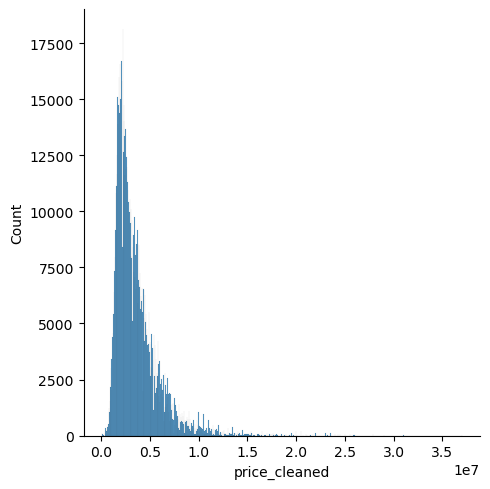

In [146]:
#distribution of housing prices
sns.displot(data['price_cleaned'])

In [156]:
data['GDP']=data['GDP'].astype(float)

data['price_cleaned']=data['price_cleaned'].astype(float)


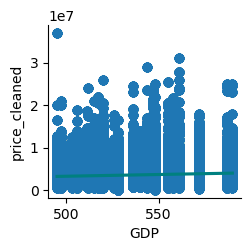

In [159]:
sns.pairplot(data, x_vars=['GDP'], y_vars='price_cleaned', kind= 'reg', plot_kws={'line_kws':{'color':'teal'}})

In [160]:
data['Salary']=data['Salary'].astype(float)

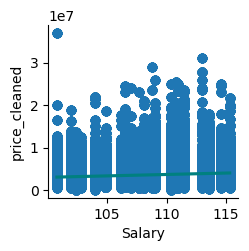

In [161]:
sns.pairplot(data, x_vars=['Salary'], y_vars='price_cleaned', kind= 'reg', plot_kws={'line_kws':{'color':'teal'}})

In [162]:
data['Inflation']=data['Inflation'].astype(float)

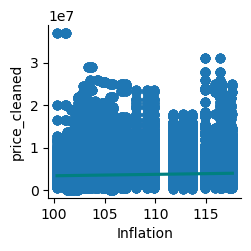

In [163]:
sns.pairplot(data, x_vars=['Inflation'], y_vars='price_cleaned', kind= 'reg', plot_kws={'line_kws':{'color':'teal'}})

In [164]:
data['Loan interest rate']=data['Loan interest rate'].astype(float)

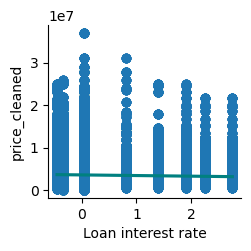

In [165]:
sns.pairplot(data, x_vars=['Loan interest rate'], y_vars='price_cleaned', kind= 'reg', plot_kws={'line_kws':{'color':'teal'}})

In [166]:
data['rooms']=data['rooms'].astype(float)


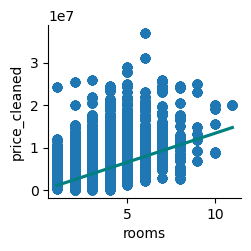

In [167]:
sns.pairplot(data, x_vars=['rooms'], y_vars='price_cleaned', kind= 'reg', plot_kws={'line_kws':{'color':'teal'}})

In [168]:
data['year built']=data['year built'].astype(float)


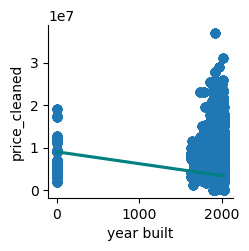

In [169]:
sns.pairplot(data, x_vars=['year built'], y_vars='price_cleaned', kind= 'reg', plot_kws={'line_kws':{'color':'teal'}})

In [170]:
#should we keep it and look at a smaller dataset 
data['kr_m2_cleaned'] = data['kr_m2_cleaned'].astype(float)

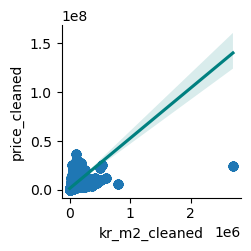

In [171]:
sns.pairplot(data, x_vars=['kr_m2_cleaned'], y_vars='price_cleaned', kind= 'reg', plot_kws={'line_kws':{'color':'teal'}})

In [172]:
data['postal_code']=data['postal_code'].astype(float) 

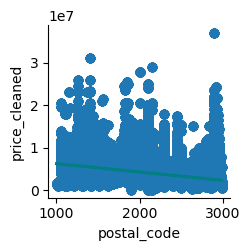

In [173]:
#is this relevant to plot
sns.pairplot(data, x_vars=['postal_code'], y_vars='price_cleaned', kind= 'reg', plot_kws={'line_kws':{'color':'teal'}})
#how do we discuss postal codes
#median 

In [178]:
data_for_heatmap=data.drop(['address', 'price', 'date', 'kr/m2'], axis=1)

In [179]:
data_for_heatmap

,GDP,Salary,Inflation,Loan interest rate,rooms,year built,m2,postal_code,price_cleaned,kr_m2_cleaned
year + quarter,,,,,,,,,,
2017K1,495.0,100.8,100.3,0.05,5.0,1885.0,110,2100.0,4495000.0,40864.0
2017K1,495.0,100.8,100.3,0.05,3.0,1963.0,70,2630.0,1375000.0,19643.0
2017K1,495.0,100.8,100.3,0.05,2.0,1934.0,58,2920.0,1850000.0,31897.0
2017K1,495.0,100.8,100.3,0.05,4.0,1961.0,86,2830.0,2285000.0,26570.0
2017K1,495.0,100.8,100.3,0.05,2.0,1935.0,53,2200.0,1850000.0,34906.0
...,...,...,...,...,...,...,...,...,...,...
2023K1,558.0,115.3,117.3,2.75,4.0,1965.0,82,2860.0,2700000.0,32927.0
2023K1,558.0,115.3,117.3,2.75,4.0,1905.0,99,1824.0,5750000.0,58081.0
2023K1,558.0,115.3,117.3,2.75,2.0,1990.0,70,2200.0,2700000.0,38571.0


C:\Users\Bruger\AppData\Local\Temp\ipykernel_22144\2430051620.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_for_heatmap.corr(), annot= True, cmap= 'coolwarm', fmt= '.2f', vmin= -1, vmax= 1)


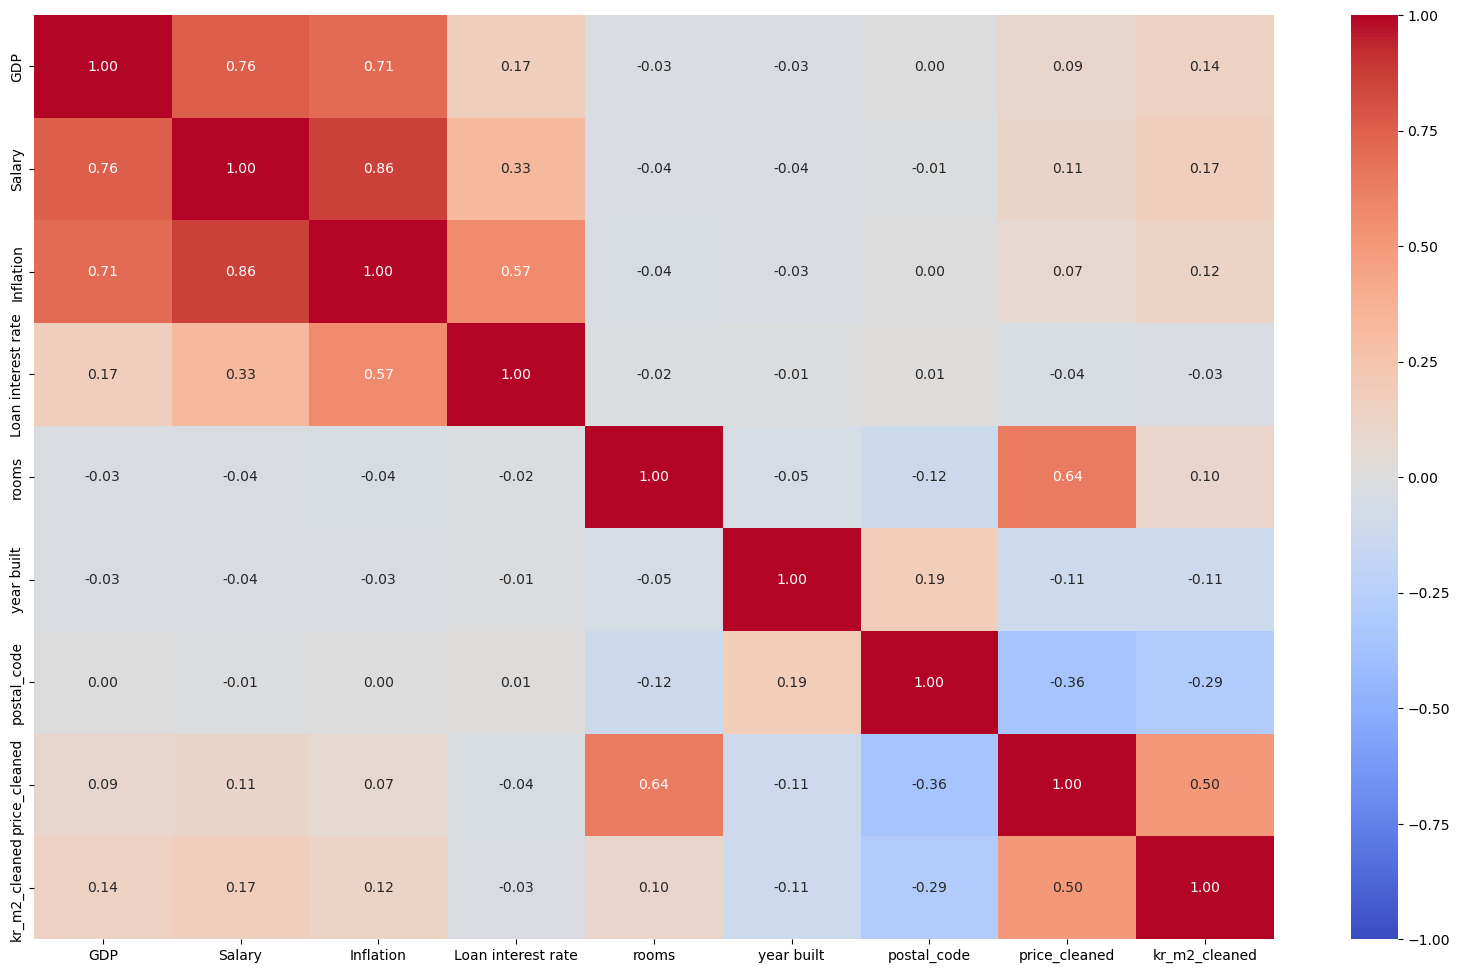

In [180]:
plt.figure(figsize = (20, 12))
sns.heatmap(data_for_heatmap.corr(), annot= True, cmap= 'coolwarm', fmt= '.2f', vmin= -1, vmax= 1)
plt.show()

C:\Users\Bruger\AppData\Local\Temp\ipykernel_22144\1974586407.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(data_for_heatmap['price_cleaned']))


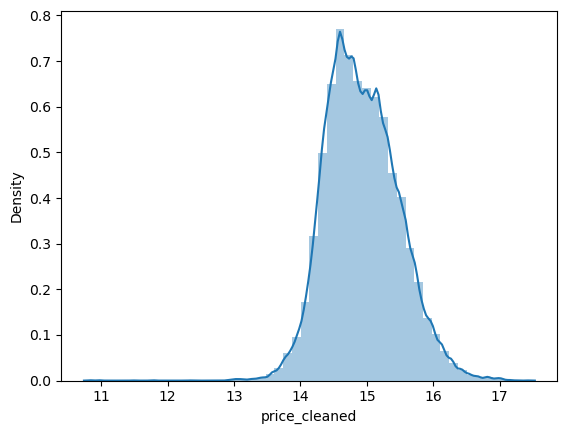

In [183]:
#transforming prices
sns.distplot(np.log(data_for_heatmap['price_cleaned']))
plt.show()